# O-mode Reflectometry simulator

Getting a simulated profile, extract the simulated signal from said profile and reconstruct the profile.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps
from refo import *
from scipy import signal
#
from skreflectometry.mode_O import refraction_index_O, refractive_matrix_O, cutoff_freq_O, abel_inversion, CalcInvPerfO
from skreflectometry.physics import cyclotron_frequency, plasma_frequency, cyclotron_field, plasma_density, upper_hybrid_frequency, distance_vacuum
from skreflectometry.reflectometry_sim import phase_delay, group_delay, beat_signal, beat_maximums
#
plt.style.use('helvet')
#

## Simulating a typical AUG L-mode density profile

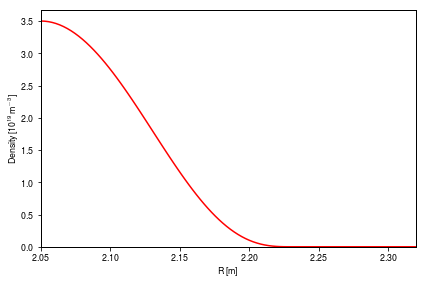

In [2]:
R0 = 2.23
Rant = 2.32
Rmid = 2.05
offR = 0.07
radius, dens = SimulDensPerf(dens0=3.5e19, Rmid=Rmid, R0=R0, Rant=Rant, m=2, n=3)
radius = np.linspace(Rmid, Rant, 100, endpoint=True)
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.plot(radius, dens*1e-19)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()
plt.show()

## Declaring a frequency sweep

In [3]:
fstart = 16e9
fstop = 50e9

In [4]:
dstart = f2n(fstart)
dstop = f2n(fstop)

In [5]:
perfmask = (dens >= dstart) & (dens <= dstop)

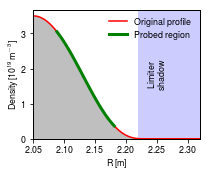

In [6]:
plt.figure(figsize=(3,2.5))
plt.plot(radius, dens*1e-19, label='Original profile')
plt.plot(radius[perfmask], dens[perfmask]*1e-19, label='Probed region', lw=3)
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)

plt.axvspan(2.22, 2.32, alpha=0.2, color='b')
plt.text(2.25, 1.8, 'Limiter\nshadow', rotation=90, horizontalalignment='center')

plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figures/profile_probe.png', dpi=300)
plt.show()

In [7]:
fpts = 1024
fprobe = np.linspace(fstart, fstop, fpts, endpoint=True)

### Refractive index

/home/guimas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


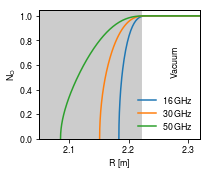

In [8]:
interpts = 8192
interp_perf = interp1d(radius, dens)
interp_rad = interp1d(dens, radius)
total_phase = []

plt.figure(figsize=(3,2.5))

fps = [16, 30, 50]
clr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

for fp, i in zip(fps, range(len(clr))):
    dens_probe = f2n(fp*1e9)
    r_int = np.linspace(interp_rad(dens_probe), Rant, interpts, endpoint=True)
    n_int = interp_perf(r_int)

    NO = np.sqrt(1-n_int/dens_probe)
    NO[0] = 0.0
    plt.plot(r_int, NO, label='$\mathrm{'+str(fp)+'\,GHz}$', color=clr[i])    


Rvac = np.min(r_int[NO>0.9995])

plt.axvspan(Rmid, Rvac, color='k', alpha=0.2)
plt.text((Rvac+2.32)/2, 0.7, 'Vacuum', rotation=90)
plt.ylabel('$\mathrm{N_{O}}$')
plt.xlabel('R [m]')
plt.legend(frameon=False, loc='best')
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()
plt.savefig('figures/omode_refindex.png', dpi=300)
plt.show()

### Total phase shift

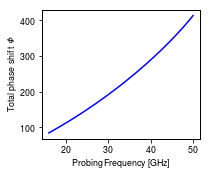

In [9]:
total_phase = []
#Avoid numerical errors due to the sqrt
epsi = 1e-15

#Do a numeric aproach 
for f in fprobe:
    dens_probe = f2n(f)
    r_int = np.linspace(interp_rad(dens_probe)+epsi, Rant, interpts, endpoint=True)
    n_int = interp_perf(r_int)
    #Refractive index
    NO = np.sqrt(1-n_int/dens_probe)
    NO[0] = 0.0
        
    #Refractive index
    total_phase.append( 4.0*np.pi*f/2.998e8*simps(NO, x=r_int)-np.pi/2 )
    
    
#Not interested in the error, hence the [0]
total_phase = np.array(total_phase)

plt.figure(figsize=(3,2.5))

plt.plot(fprobe*1e-9, total_phase, color='b')
plt.xlabel('$\mathrm{Probing\,Frequency\,[GHz]}$')
plt.ylabel('Total phase shift $\Phi$')
plt.tight_layout()
plt.savefig('figures/total_phase_shift.png', dpi=300)
plt.show()

#### Total theoretical phase shift

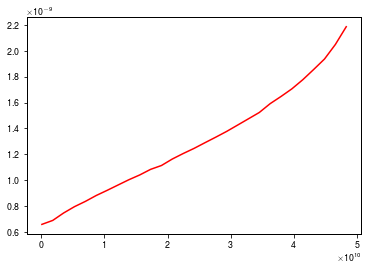

In [10]:
fs_O = np.linspace(.1e9, 50e9, 30)
#
n_index_O = refractive_matrix_O(dens, fs_O)
phi_O = phase_delay(fs_O, radius, n_index_O, reflect_at_wall=True, antenna_side='lfs')
delta_t_O = group_delay(fs_O, phi_O)
#
mksfs = fs_O<49e9
fs_O, delta_t_O = fs_O[mksfs], delta_t_O[mksfs]
plt.plot(fs_O, delta_t_O)
plt.show()

### Simulated signal

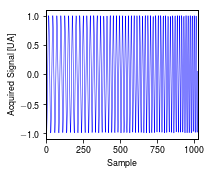

In [11]:
plt.figure(figsize=(3,2.5))
sig = np.cos(total_phase)
plt.xlabel('Sample')
plt.ylabel('Acquired Signal [UA]')
plt.plot(sig, color='blue', lw=0.5)
plt.xlim(0, fpts)
plt.tight_layout()
plt.savefig('figures/simulated_signal.png', dpi=300)
plt.show()

### Spectral analysis

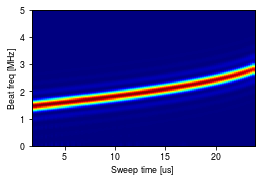

In [12]:
fsamp = 40e6
f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)

plt.figure(figsize=(4,2.5))

plt.pcolormesh(t, f, Sxx, cmap='jet')
plt.ylim(0, 5.0)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [MHz]')
plt.show()

### Extracting the beat frequency

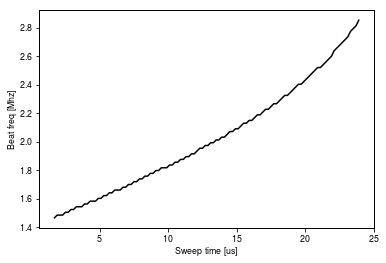

In [13]:
beat_f = f[np.argmax(Sxx, axis=0)]

plt.plot(t, beat_f, color='k')

#plt.ylim(0, 2.)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [Mhz]')
plt.show()

### Best-path?

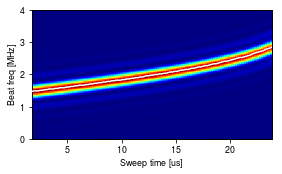

In [14]:
fsamp = 40e6
f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)

beat_f = f[np.argmax(Sxx, axis=0)]

plt.figure(figsize=(4,2.5))

plt.pcolormesh(t, f, Sxx, cmap='jet')
plt.plot(t, beat_f, zorder=10, color='w')
plt.ylim(0, 4.0)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [MHz]')
plt.tight_layout()
plt.savefig('figures/Mapping_bp.png', dpi=300)
plt.show()

In [15]:
Swp_rate = (fstop-fstart) / (1024.0/fsamp)
print Swp_rate

1.328125e+15


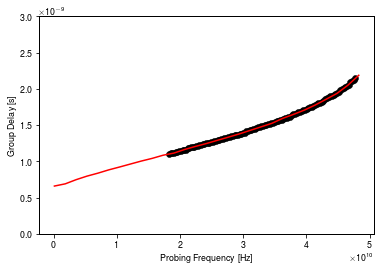

In [16]:
tau_g = beat_f*1e6 / Swp_rate
f_probsw = t*1e-6/(1024.0/fsamp)*(fstop-fstart) + fstart

plt.scatter(f_probsw, tau_g, color='k')
plt.plot(fs_O, delta_t_O, color='r')

plt.ylim(0, 3e-9)
plt.xlabel('Probing Frequency [Hz]')
plt.ylabel('Group Delay [s]')
plt.show()

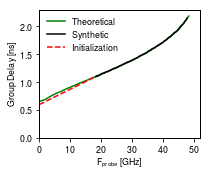

In [17]:
plt.figure(figsize=(3,2.5))

Rinit = 2.23
init_pts = 32
init_fpro = np.linspace(0.0, f_probsw[0], init_pts)
vac_gdel_example = (2.32-Rinit)*2.0/2.998e8
init_tau = np.linspace(vac_gdel_example, tau_g[0], init_pts)

plt.plot(fs_O*1e-9, delta_t_O*1e9, color='g', label='Theoretical')
plt.plot(f_probsw*1e-9, tau_g*1e9, color='k', label='Synthetic')
plt.plot(init_fpro*1e-9, init_tau*1e9, color='r', ls='--', label='Initialization')

plt.legend(frameon=False, loc='best')
plt.ylim(0.0, 2.3)
plt.xlim(0, 52)
plt.xlabel('$\mathrm{F_{probe}\,[GHz]}$')
plt.ylabel('$\mathrm{Group\,Delay\,[ns]}$')
plt.xticks([0,10,20,30,40,50])
plt.tight_layout()
plt.savefig('figures/group_delay_final.png', dpi=300)
plt.show()

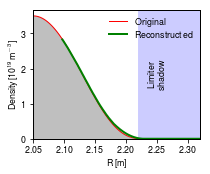

In [18]:
plt.figure(figsize=(3,2.5))
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()

r, n, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-Rinit)
plt.plot(radius, dens*1e-19, label='Original', lw=1)
R_reco = Rant-r
plt.plot(R_reco, n*1e-19, label='Reconstructed', lw=2)

plt.axvspan(2.22, 2.32, alpha=0.2, color='b')
plt.text(2.25, 1.8, 'Limiter\nshadow', rotation=90, horizontalalignment='center')

plt.xlim(Rmid, Rant)
plt.legend(frameon=False)
plt.tight_layout()

plt.savefig('figures/Reconstructed_profile.png', dpi=300)
plt.show()

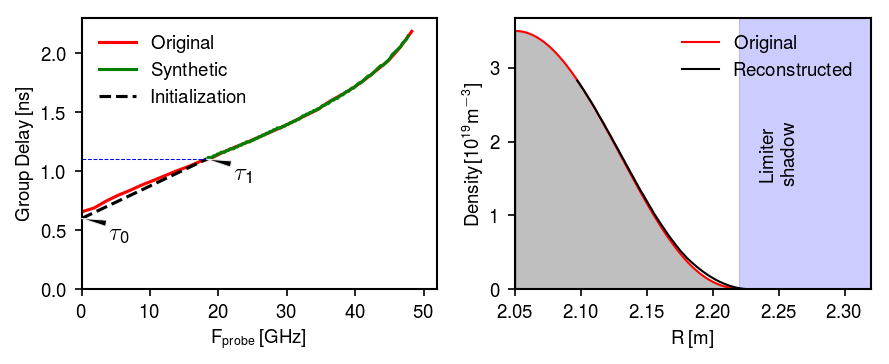

In [49]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(6,2.5), dpi=150)

Rinit = 2.23
init_pts = 32
init_fpro = np.linspace(0.0, f_probsw[0], init_pts)
vac_gdel_example = (2.32-Rinit)*2.0/2.998e8
init_tau = np.linspace(vac_gdel_example, tau_g[0], init_pts)

ax[0].plot(fs_O*1e-9, delta_t_O*1e9, color='r', label='Original')
ax[0].plot(f_probsw*1e-9, tau_g*1e9, color='g', label='Synthetic')
ax[0].plot(init_fpro*1e-9, init_tau*1e9, color='k', ls='--', label='Initialization')

ax[0].legend(frameon=False, loc='best')
ax[0].set_ylim(0.0, 2.3)
ax[0].set_xlim(0, 52)
ax[0].set_xlabel('$\mathrm{F_{probe}\,[GHz]}$')
ax[0].set_ylabel('$\mathrm{Group\,Delay\,[ns]}$')
ax[0].set_xticks([0,10,20,30,40,50])
ax[0].annotate(r'$\mathrm{\tau_{0}}$', xy=(0,init_tau[0]*1e9),
               xytext=(4,init_tau[0]*1e9-0.2),
               arrowprops=dict(facecolor='black', shrink=0.5, width=2, headwidth=3), fontsize=12)

ax[0].annotate(r'$\mathrm{\tau_{1}}$', xy=(init_fpro[-1]*1e-9,init_tau[-1]*1e9),
               xytext=(init_fpro[-1]*1e-9+4, init_tau[-1]*1e9-0.2),
               arrowprops=dict(facecolor='black', shrink=0.5, width=2, headwidth=3), fontsize=12)

ax[0].axhline(init_tau[-1]*1e9, xmin=0, xmax=init_fpro[-1]*1e-9/52, ls='--', lw='0.5', color='b')

#ax[0].annotate(r'$\mathrm{\tau_{0}}$', xy=(0,init_tau[0]*1e19), xytext=(3,0.2),
#              arrowprops=dict(facecolor='black', shrink=0.05))
#plt.savefig('figures/group_delay_final.png', dpi=300)

######################################
ax[1].set_xlabel('$\mathrm{R\,[m]}$')
ax[1].set_ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
ax[1].fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
ax[1].set_ylim(bottom=0)

r, n, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-Rinit)
ax[1].plot(radius, dens*1e-19, label='Original', lw=1, color='r')
R_reco = Rant-r
ax[1].plot(R_reco, n*1e-19, label='Reconstructed', lw=1, color='k')

ax[1].axvspan(2.22, 2.32, alpha=0.2, color='b')
ax[1].text(2.25, 1.8, 'Limiter\nshadow', rotation=90, horizontalalignment='center')

ax[1].set_xlim(Rmid, Rant)
ax[1].legend(frameon=False)

plt.tight_layout()
plt.savefig('figures/groupdelay_profile.png', dpi=300)
plt.show()

In [20]:
pwd

u'/home/guimas/Documents/ReflectometryCookbook/notebooks'

### Compute the differences between method and original data

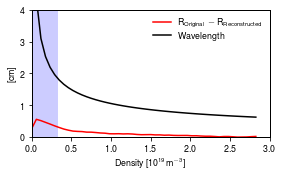

In [21]:
mindens = 0.001e19
maxdens = max(n)
densdiff = np.linspace(mindens, maxdens, endpoint=True)

interp_orig_data = interp1d(dens, radius)
interp_reco_data = interp1d(n, R_reco)
plt.figure(figsize=(4,2.5))
plt.axvspan(0,f2n(16e9)*1e-19, color='b', alpha=0.2)
plt.plot(densdiff*1e-19, np.abs(interp_orig_data(densdiff)-interp_reco_data(densdiff))*1e2,
         label='$\mathrm{R_{Original}-R_{Reconstructed}}$')
plt.plot(densdiff*1e-19, 2.998e8/(n2f(densdiff))*1e2, color='k', label='Wavelength')
plt.xlim(0,3)
plt.ylabel('$\mathrm{[cm]}$')
plt.xlabel('$\mathrm{Density\,[10^{19}m^{-3}]}$')
plt.legend(frameon=False)
plt.ylim(0,4)
plt.tight_layout()
plt.savefig('figures/uncertainty.png', dpi=300)

#### Excellent initialization

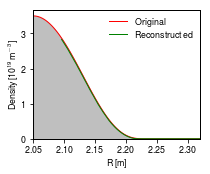

In [22]:
plt.figure(figsize=(3,2.5))
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()

Rinit = 2.22
r, n, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-Rinit)
plt.plot(radius, dens*1e-19, label='Original', lw=1)
R_reco = Rant-r
plt.plot(R_reco, n*1e-19, label='Reconstructed', lw=1)
plt.xlim(2.05, 2.32)
plt.legend(frameon=False)
plt.tight_layout()

plt.savefig('figures/excellent_reconstructed_profile.png', dpi=300)
plt.show()

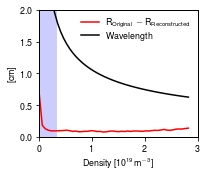

In [23]:
mindens = 0.001e19
maxdens = max(n)
densdiff = np.linspace(mindens, maxdens, endpoint=True)

interp_orig_data = interp1d(dens, radius)
interp_reco_data = interp1d(n, R_reco)

plt.figure(figsize=(3,2.5))
plt.axvspan(0,f2n(16e9)*1e-19, color='b', alpha=0.2)
plt.plot(densdiff*1e-19, np.abs(interp_orig_data(densdiff)-interp_reco_data(densdiff))*1e2,
         label='$\mathrm{R_{Original}-R_{Reconstructed}}$')
plt.plot(densdiff*1e-19, 2.998e8/(n2f(densdiff))*1e2, color='k', label='Wavelength')
plt.xlim(0,3)
plt.ylabel('$\mathrm{[cm]}$')
plt.xlabel('$\mathrm{Density\,[10^{19}m^{-3}]}$')
plt.legend(frameon=False)
plt.ylim(0,2)
plt.tight_layout()
plt.savefig('figures/excellent_uncertainty.png', dpi=300)